In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [7]:
import pandas as pd
df = pd.read_csv('/content/sample_data/sms_spam.csv')

In [8]:
df.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


In [9]:
df.columns

Index(['type', 'text'], dtype='object')

In [12]:
df.groupby('type').describe()

text                                                               
     count unique                                                top freq
type                                                                     
ham   4812   4503                             Sorry, I'll call later   30
spam   747    653  Please call our customer service representativ...    4

In [13]:
df['type'].value_counts()

ham     4812
spam     747
Name: type, dtype: int64

In [14]:
# this is an imbalanced datasets so we will undersample it to balance it 
#there are other ways as well such as SMOTE and oversampling minority class
747/4812 
#( here we are going by simple approch)


0.1552369077306733

In [16]:
df_spam = df[df['type']== 'spam']
df_spam.shape

(747, 2)

In [17]:
df_ham = df[df['type']=='ham']

df_ham.shape

(4812, 2)

In [18]:
df_ham.sample(2)

,type,text
3570,ham,When you are big..| God will bring success.
4239,ham,what is your account number?


In [19]:
df_ham_downsample = df_ham.sample(df_spam.shape[0])
df_ham_downsample.shape

(747, 2)

In [21]:
# now we will concatinate bothe the dataset 
df_balanced = pd.concat([df_spam,df_ham_downsample])
df_balanced.shape

(1494, 2)

In [23]:
df_balanced['type'].value_counts()

spam    747
ham     747
Name: type, dtype: int64

In [26]:
df_balanced.sample(5)

,type,text
4113,spam,Urgent UR awarded a complimentary trip to Euro...
2790,spam,BangBabes Ur order is on the way. U SHOULD rec...
2366,ham,tap & spile at seven. * Is that pub on gas st ...
4076,ham,Dont gimme that lip caveboy
5074,ham,"I'm an actor. When i work, i work in the eveni..."


In [30]:
df_balanced['spam']=df_balanced['type'].apply(lambda x: 1 if x=='spam' else 0)

In [32]:
df_balanced.sample(5)

,type,text,spam
5367,spam,Get a brand new mobile phone by being an agent...,1
401,spam,YOU 07801543489 are guaranteed the latests Nok...,1
4286,ham,"Whenevr ur sad, Whenevr ur gray, Remembr im he...",0
4052,spam,We tried to contact you re your reply to our o...,1
4706,spam,You have won a guaranteed £200 award or even £...,1


In [33]:
from sklearn.model_selection import train_test_split
X_train, x_test, Y_train,y_test = train_test_split(df_balanced['text'],df_balanced['spam'],stratify=df_balanced['spam'])

In [36]:
X_train.head(4)

24        Could you not read me, my Love ? I answered you
4670    Free 1st week entry 2 TEXTPOD 4 a chance 2 win...
4153    Sure, if I get an acknowledgement from you tha...
2008    Nope wif my sis lor... Aft bathing my dog then...
Name: text, dtype: object

In [37]:
bert_process = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [38]:
bert_preprocess = bert_process

In [40]:
# we will change now text to vector
def get_sentence_embeding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
     "500$ discount. hurry up"
     "Bruce, are you up for a volleyball game tomorrow"                  
])


<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-8.39025617e-01, -5.13813734e-01, -9.51817513e-01,
         7.30669200e-01,  7.81262636e-01, -1.89104959e-01,
         7.79591501e-01,  3.50309998e-01, -8.67254734e-01,
        -9.99977648e-01, -6.91893280e-01,  9.26568508e-01,
         9.66563463e-01,  6.50955260e-01,  8.64349902e-01,
        -7.07003057e-01, -2.89691061e-01, -6.36357546e-01,
         2.58588225e-01,  1.64557531e-01,  5.51032305e-01,
         9.99996841e-01, -7.34829828e-02,  2.75680572e-01,
         4.97888744e-01,  9.91961300e-01, -8.12384903e-01,
         8.85936320e-01,  9.26385224e-01,  5.86375177e-01,
        -4.36013043e-01,  1.56614557e-01, -9.73763525e-01,
        -3.50685745e-01, -9.46337819e-01, -9.91601527e-01,
         3.84132773e-01, -6.84077442e-01,  6.83104713e-03,
         7.14796409e-02, -8.14062357e-01,  3.12948614e-01,
         9.99974191e-01,  2.62498468e-01,  2.97461659e-01,
        -2.52689362e-01, -1.00000000e+00,  2.11532459e-01,
      

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity 

<function sklearn.metrics.pairwise.cosine_similarity>

In [44]:
#creating Bert layers 
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name ="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)


In [51]:
#creating Neural Network layers 
l = tf.keras.layers.Dropout(0.1, name ='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(l)

#construct final model  
model = tf.keras.Model(inputs =[text_input], outputs = [l])

In [52]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [53]:
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [55]:
model.fit(X_train,Y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 505s 14s/step - loss: 0.6614 - accuracy: 0.6071 - precision: 0.6158 - recall: 0.5696
Epoch 2/10
35/35 [==============================] - 480s 14s/step - loss: 0.5269 - accuracy: 0.8134 - precision: 0.7970 - recall: 0.8411
Epoch 3/10
35/35 [==============================] - 477s 14s/step - loss: 0.4504 - accuracy: 0.8518 - precision: 0.8283 - recall: 0.8875
Epoch 4/10
35/35 [==============================] - 481s 14s/step - loss: 0.4024 - accuracy: 0.8732 - precision: 0.8616 - recall: 0.8893
Epoch 5/10
35/35 [==============================] - 501s 14s/step - loss: 0.3730 - accuracy: 0.8759 - precision: 0.8648 - recall: 0.8911
Epoch 6/10
35/35 [==============================] - 500s 14s/step - loss: 0.3457 - accuracy: 0.8911 - precision: 0.8750 - recall: 0.9125
Epoch 7/10
35/35 [==============================] - 491s 14s/step - loss: 0.3306 - accuracy: 0.8848 - precision: 0.8646 - recall: 0.9125
Epoch 8/10
35/35 [=======================

In [56]:
model.evaluate(x_test,y_test)

12/12 [==============================] - 172s 14s/step - loss: 0.2667 - accuracy: 0.9144 - precision: 0.9016 - recall: 0.9305


[0.26668766140937805,
 0.9144384860992432,
 0.9015544056892395,
 0.9304812550544739]

In [57]:
y_predicted = model.predict(x_test)
y_predicted = y_predicted.flatten() #converting 2 dimention array to one dimention array

In [58]:
import numpy as np 
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[168,  19],
       [ 13, 174]])

Text(33.0, 0.5, 'Truth')

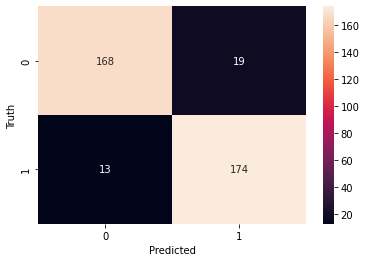

In [60]:
from matplotlib import pyplot as plt 
import seaborn as sns
sns.heatmap(cm, annot=True, fmt= 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [63]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       187
           1       0.90      0.93      0.92       187

    accuracy                           0.91       374
   macro avg       0.91      0.91      0.91       374
weighted avg       0.91      0.91      0.91       374

